# Νευρωνικό Δίκτυο

In [16]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import StratifiedKFold

import keras
from keras.models import Sequential # type: ignore
from keras.layers import Dense, Input # type: ignore

import matplotlib.pyplot as plt

# Unused columns
drop_cols = ['PatientID', 'DoctorInCharge']

categorical_cols = ['Gender', 'Ethnicity', 'EducationLevel']

numerical_cols = [
    'Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 
    'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
    'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides',
    'MMSE', 'FunctionalAssessment', 'ADL'
]

# Preprocessing pipelines
standard_scaler = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(transformers=[
    ('num', standard_scaler, numerical_cols),
    ('cat', categorical_transformer, categorical_cols),
], remainder='passthrough')  # leaves binary columns as they are

# Load dataset
df = pd.read_csv("alzheimers_disease_data.csv")  # Load your real dataset
df = df.drop(columns=drop_cols)

# Separate input and output
X = df.drop(columns=['Diagnosis'])  # Adjust target if needed
Y = df['Diagnosis']

# Fit-transform your data
X = preprocessor.fit_transform(X)
input_processed = pd.DataFrame(X, columns=preprocessor.get_feature_names_out())

In [17]:
I = X.shape[1]  # Number of columns
H = 2*I

h = 0.001
m = 0.6 # Momentum

r = 0.001

# Split the data into a balanced 5-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True)

hidden_layer_activation = 'relu'  # Activation function for hidden layers
output_activation = 'sigmoid'  # For binary classification

epochs = 100
batch_size = 50

# Early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=5,
    restore_best_weights=True,
)

In [ ]:
# Αποθήκευση τιμών για το διάγραμμα
avg_loss_per_epoch = np.zeros(epochs)
avg_mse_per_epoch = np.zeros(epochs)
avg_acc_per_epoch = np.zeros(epochs)
lossList = []
mseList = []
accuracyList = []

best_model = None
best_score = -float('inf')

for j, (train, test) in enumerate(kfold.split(X, Y)):
    # Δημιουργία μοντέλου
    model = Sequential()
    model.add(Input(shape=(I,)))
    model.add(Dense(H, activation=hidden_layer_activation, kernel_regularizer=keras.regularizers.l2(r)))
    model.add(Dense(1, activation=output_activation, kernel_regularizer=keras.regularizers.l2(r)))

    # Compile model
    optimizer = keras.optimizers.SGD(learning_rate=h, momentum=m)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['mse', 'accuracy'])

    # Εκπαίδευση μοντέλου και αποθήκευση ιστορικού
    history = model.fit(X[train], Y[train], epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping])

    # Αποθήκευση της απώλειας και της ακρίβειας ανά εποχή
    avg_loss_per_epoch += np.array(history.history['loss']) / kfold.get_n_splits()
    avg_mse_per_epoch += np.array(history.history['mse']) / kfold.get_n_splits()
    avg_acc_per_epoch += np.array(history.history['accuracy']) / kfold.get_n_splits()

    # Αξιολόγηση μοντέλου
    scores = model.evaluate(X[test], Y[test], verbose=0)
    val_accuracy = scores[2]

    lossList.append(scores[0])
    mseList.append(scores[1])
    accuracyList.append(scores[2])

    # Save best model (based on lowest loss)
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_model = keras.models.clone_model(model)  # clone structure
        best_model.set_weights(model.get_weights())   # copy weights
        # After training with KFold, take one split to use in GA
        X_val = X[test]  # from the best fold
        y_val = Y[test]
        np.save("X_val.npy", X_val)
        np.save("y_val.npy", y_val)

    print(f"Fold {j}: Loss={scores[0]:.4f}, MSE={scores[1]:.4f}, Accuracy={scores[2]:.4f}")

print(f"Average Loss: {np.mean(lossList):.4f}")
print(f"Average MSE: {np.mean(mseList):.4f}")
print(f"Average Accuracy: {np.mean(accuracyList):.4f}")

# Σχεδίαση των γραφημάτων σύγκλισης
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs + 1), avg_loss_per_epoch, linestyle='-', color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Loss per Epoch")
plt.grid()

# MSE Plot
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs + 1), avg_mse_per_epoch, linestyle='-', color='g')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title(f"MSE per Epoch")
plt.grid()

# Accuracy Plot
plt.subplot(1, 3, 3)
plt.plot(range(1, epochs + 1), avg_acc_per_epoch, linestyle='-', color='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title(f"Accuracy per Epoch")
plt.grid()

plt.show()




best_model.save("best_model.keras")
print("Best model saved with validation accuracy:", best_score)


# Γεννετικός Αλγόριθμος

In [1]:
import numpy as np
# === Φορτώνουμε τα δεδομένα ===
X_val = np.load("X_val.npy")  # (num_samples, 34)
y_val = np.load("y_val.npy")  # (num_samples,)

# === Προϋπάρχον εκπαιδευμένο μοντέλο ===
from tensorflow.keras.models import load_model # type: ignore
model = load_model("best_model.keras")  # ή βάλε το μοντέλο σου

2025-06-14 18:53:05.131558: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-14 18:53:05.132157: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-14 18:53:05.135709: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-14 18:53:05.144449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749916385.158899 2363880 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749916385.16

In [2]:
from deap import base, creator, tools, algorithms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

N_FEATURES = X_val.shape[1]
PENALTY_WEIGHT = 0.01

# Βαθμολόγηση ατόμου
def eval_individual(individual):
    if sum(individual) == 0:
        return 0.0,  # Απόρριψη (χωρίς χαρακτηριστικά)

    selected_indices = [i for i, bit in enumerate(individual) if bit == 1]
    X_selected = X_val[:, selected_indices]

    # Προσαρμογή input στο πλήρες input του μοντέλου (zero-padding)
    X_model_input = np.zeros_like(X_val)
    X_model_input[:, selected_indices] = X_selected

    y_pred = (model.predict(X_model_input, verbose=0) >= 0.5).astype(int).flatten()
    accuracy = accuracy_score(y_val, y_pred)

    # Ποινή για αριθμό χαρακτηριστικών
    penalty = PENALTY_WEIGHT * (sum(individual) / N_FEATURES)

    return accuracy - penalty,

# DEAP setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, N_FEATURES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", eval_individual)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.0)
toolbox.register("select", tools.selTournament, tournsize=3)


def run_ga(cxpb=0.6, mutpb=0.0, pop_size=20, ngen=1000):
    population = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("max", np.max)

    # Τερματισμός: στασιμότητα ή μικρή βελτίωση
    early_stop_limit = 20
    no_improve = 0
    prev_best = 0
    max_per_gen = []

    for gen in range(ngen):
        offspring = algorithms.varAnd(population, toolbox, cxpb, mutpb)
        fits = list(map(toolbox.evaluate, offspring))
        for ind, fit in zip(offspring, fits):
            ind.fitness.values = fit

        population = toolbox.select(offspring, len(population))
        hof.update(population)

        max_fit = max(ind.fitness.values[0] for ind in population)
        max_per_gen.append(max_fit)

        if max_fit - prev_best < 0.01:
            no_improve += 1
        else:
            no_improve = 0
            prev_best = max_fit

        if no_improve >= early_stop_limit:
            print(f"Early stopping at generation {gen}")
            break

    print("Best fitness:", hof[0].fitness.values[0])
    return hof[0], max_per_gen, gen

def multiple_runs_ga(n_runs=10, **ga_params):
    all_max_fitness = []
    best_fitnesses = []
    gens_per_run = []
    best_individuals = []

    for run in range(n_runs):
        print(f"\nRun {run + 1}/{n_runs}")
        best_individual, max_per_gen, gen = run_ga(**ga_params)
        best_fitnesses.append(best_individual.fitness.values[0])
        all_max_fitness.append(max_per_gen)
        gens_per_run.append(gen)
        best_individuals.append(best_individual)

    # Υπολογισμός μέσου όρου της καμπύλης max fitness ανά γενιά
    min_length = min(len(x) for x in all_max_fitness)
    trimmed = [x[:min_length] for x in all_max_fitness]  # για ίσο μήκος
    avg_max_fitness = np.mean(trimmed, axis=0)
    print(f"\nΜέση απόδοση βέλτιστων ατόμων μετά από {n_runs} επαναλήψεις: {np.mean(best_fitnesses):.4f}")
    print(f"Μέσος αριθμός γενεών: {np.mean(gens_per_run)}")

    # Σχεδίαση μέσης καμπύλης βελτίωσης
    plt.figure(figsize=(10, 5))
    plt.plot(avg_max_fitness, label="Μέγιστο Fitness ανά Γενιά (Μέσος Όρος)")
    plt.xlabel("Γενιά")
    plt.ylabel("Fitness")
    plt.title(f"Μέση Καμπύλη Εξέλιξης Γενετικού Αλγορίθμου\n"
          f"(pop_size={ga_params.get('pop_size')}, cxpb={ga_params.get('cxpb')}, mutpb={ga_params.get('mutpb')})")
    plt.grid(True)
    plt.legend()
    plt.show()

    return avg_max_fitness, best_fitnesses, best_individuals


Parameters 1/10: pop_size=20, cxpb=0.6, mutpb=0.0

Run 1/10
Early stopping at generation 26
Best fitness: 0.8139892665474061

Run 2/10
Early stopping at generation 24
Best fitness: 0.8145199761478832

Run 3/10
Early stopping at generation 29
Best fitness: 0.8194096601073345

Run 4/10
Early stopping at generation 31
Best fitness: 0.8238223017292785

Run 5/10
Early stopping at generation 30
Best fitness: 0.8222659511031604

Run 6/10
Early stopping at generation 25
Best fitness: 0.8036612999403697

Run 7/10
Early stopping at generation 27
Best fitness: 0.8248479427549195

Run 8/10
Early stopping at generation 30
Best fitness: 0.8294991055456171

Run 9/10
Early stopping at generation 23
Best fitness: 0.8227787716159809

Run 10/10
Early stopping at generation 34
Best fitness: 0.8344066785927251

Μέση απόδοση βέλτιστων ατόμων μετά από 10 επαναλήψεις: 0.8209
Μέσος αριθμός γενεών: 27.9


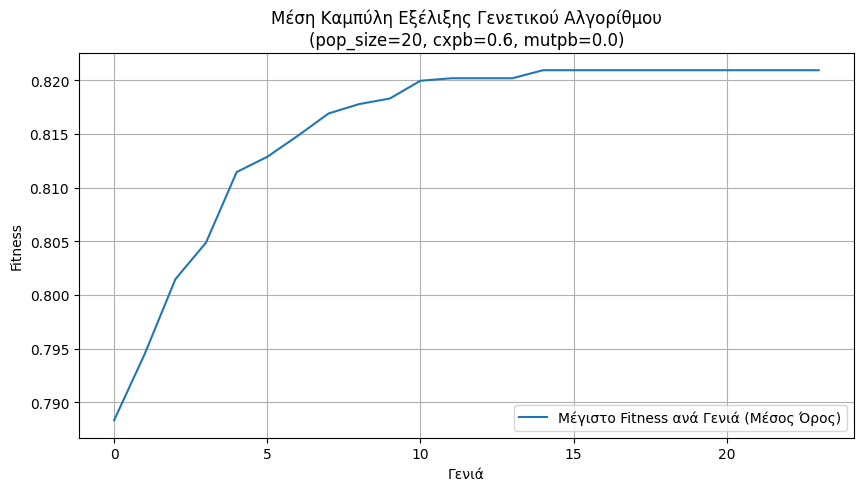

Run 1: Features: [0, 2, 3, 4, 9, 10, 11, 12, 13, 14, 15, 16, 22, 23, 25, 32, 33, 38] Features used: 18, Accuracy: 0.8186
Run 2: Features: [0, 2, 4, 5, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 29, 30, 31, 32, 34, 38] Features used: 25, Accuracy: 0.8209
Run 3: Features: [3, 4, 11, 12, 13, 14, 17, 19, 22, 26, 27, 29, 31, 32, 34] Features used: 15, Accuracy: 0.8233
Run 4: Features: [0, 1, 2, 4, 8, 10, 11, 12, 13, 14, 15, 19, 20, 21, 22, 23, 25, 26, 32, 33, 34, 35, 36, 37, 38] Features used: 25, Accuracy: 0.8302
Run 5: Features: [2, 4, 6, 10, 11, 12, 13, 14, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 35, 37] Features used: 22, Accuracy: 0.8279
Run 6: Features: [2, 3, 4, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 20, 21, 23, 24, 25, 31, 35, 36, 38] Features used: 22, Accuracy: 0.8093
Run 7: Features: [0, 2, 4, 12, 13, 14, 15, 16, 18, 19, 20, 22, 23, 25, 28, 29, 31, 32, 33, 36, 37] Features used: 21, Accuracy: 0.8302
Run 8: Features: [0, 4, 8, 9, 12, 13, 14, 15, 16, 18, 19, 2

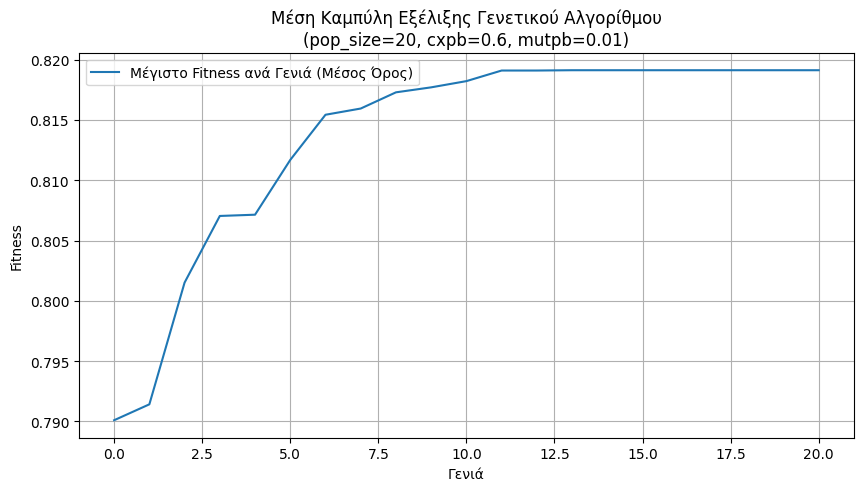

Run 1: Features: [0, 1, 3, 4, 6, 10, 12, 13, 14, 15, 17, 19, 22, 23, 25, 26, 29, 31, 32, 33, 35] Features used: 21, Accuracy: 0.8186
Run 2: Features: [1, 2, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 25, 26, 30, 32, 33, 34] Features used: 24, Accuracy: 0.8349
Run 3: Features: [2, 4, 5, 11, 12, 13, 14, 16, 18, 19, 21, 22, 23, 26, 28, 29, 32, 34, 36] Features used: 19, Accuracy: 0.8302
Run 4: Features: [2, 3, 4, 11, 12, 13, 14, 15, 16, 17, 24, 26, 28, 32, 34, 37] Features used: 16, Accuracy: 0.8256
Run 5: Features: [1, 2, 4, 6, 7, 11, 12, 13, 14, 15, 16, 17, 19, 24, 30, 31, 32, 33, 36, 38] Features used: 20, Accuracy: 0.8116
Run 6: Features: [2, 3, 4, 7, 8, 9, 10, 12, 13, 14, 15, 18, 20, 22, 23, 25, 30, 31, 32, 33, 34, 35, 36] Features used: 23, Accuracy: 0.8209
Run 7: Features: [2, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 21, 22, 23, 24, 29, 30, 32, 34] Features used: 21, Accuracy: 0.8256
Run 8: Features: [2, 3, 4, 5, 11, 12, 13, 14, 15, 16, 19, 20, 23, 25, 28, 29, 30,

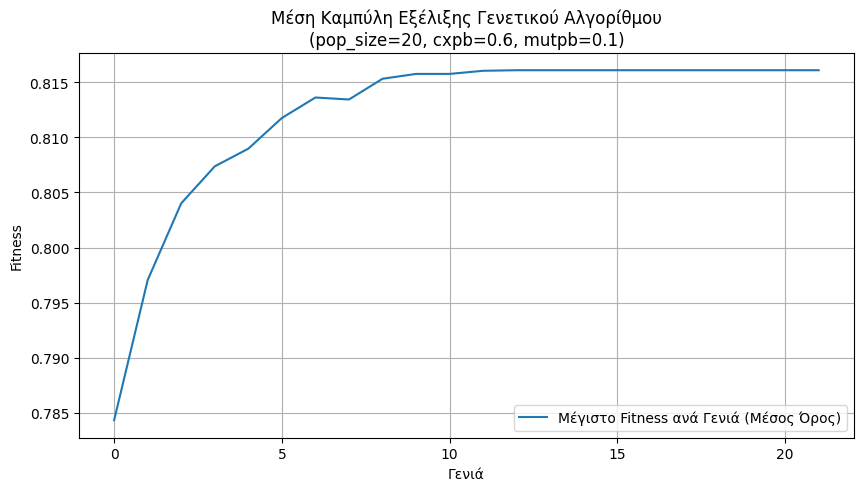

Run 1: Features: [1, 2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 20, 22, 23, 24, 25, 28, 29, 30, 32, 33, 34] Features used: 23, Accuracy: 0.8279
Run 2: Features: [2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 25, 26, 30, 31, 32, 33, 34, 38] Features used: 25, Accuracy: 0.8279
Run 3: Features: [2, 4, 5, 6, 9, 10, 12, 13, 14, 15, 16, 22, 23, 24, 25, 30, 32, 35, 36] Features used: 19, Accuracy: 0.8302
Run 4: Features: [2, 5, 7, 10, 11, 12, 13, 14, 15, 17, 23, 24, 25, 26, 29, 31, 32, 36, 38] Features used: 19, Accuracy: 0.8116
Run 5: Features: [3, 4, 5, 7, 12, 13, 14, 15, 16, 20, 22, 23, 24, 25, 31, 32, 33, 35] Features used: 18, Accuracy: 0.8256
Run 6: Features: [3, 4, 5, 8, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 26, 27, 28, 29, 30, 31, 32, 33, 34] Features used: 24, Accuracy: 0.8256
Run 7: Features: [4, 5, 8, 11, 12, 13, 14, 15, 16, 22, 23, 25, 26, 31, 32, 33, 36, 37, 38] Features used: 19, Accuracy: 0.8326
Run 8: Features: [0, 1, 4, 9, 12, 13, 14, 15, 16, 17, 18, 22, 24, 2

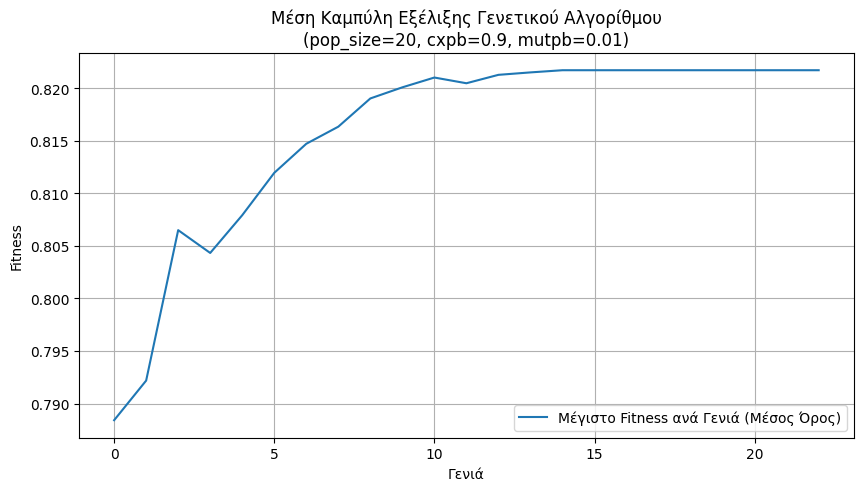

Run 1: Features: [0, 4, 8, 9, 11, 12, 13, 14, 15, 20, 22, 23, 24, 25, 28, 31, 32, 33, 38] Features used: 19, Accuracy: 0.8349
Run 2: Features: [0, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 25, 26, 29, 30, 31, 32, 34, 38] Features used: 23, Accuracy: 0.8209
Run 3: Features: [1, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 23, 24, 26, 30, 31, 32, 33, 36] Features used: 22, Accuracy: 0.8163
Run 4: Features: [0, 3, 5, 7, 10, 11, 12, 13, 14, 16, 17, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 36, 38] Features used: 24, Accuracy: 0.8163
Run 5: Features: [2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 25, 29, 31, 32, 34, 36] Features used: 24, Accuracy: 0.8233
Run 6: Features: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 23, 24, 25, 29, 30, 31, 32, 33] Features used: 27, Accuracy: 0.8326
Run 7: Features: [3, 4, 7, 8, 9, 10, 12, 13, 14, 15, 18, 19, 20, 22, 23, 24, 26, 31, 32, 33, 38] Features used: 21, Accuracy: 0.8326
Run 8: Features: [0,

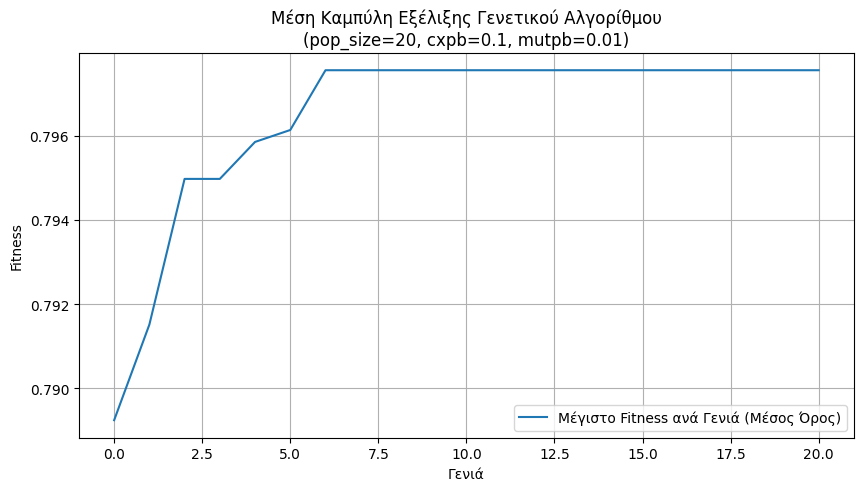

Run 1: Features: [2, 5, 6, 8, 10, 11, 12, 13, 14, 16, 19, 24, 25, 26, 30, 31, 32, 33, 36, 37, 38] Features used: 21, Accuracy: 0.7977
Run 2: Features: [1, 2, 10, 12, 13, 14, 15, 19, 21, 22, 24, 25, 26, 27, 28, 29, 32] Features used: 17, Accuracy: 0.8163
Run 3: Features: [6, 8, 10, 11, 12, 13, 14, 15, 17, 19, 21, 22, 23, 24, 26, 28, 29, 32, 33, 35, 36, 38] Features used: 22, Accuracy: 0.8116
Run 4: Features: [0, 2, 3, 5, 6, 9, 10, 12, 13, 14, 15, 18, 19, 22, 25, 26, 28, 29, 30, 31, 32, 33, 34, 36] Features used: 24, Accuracy: 0.8233
Run 5: Features: [2, 4, 5, 6, 7, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 27, 29, 30, 31, 32, 33, 37] Features used: 24, Accuracy: 0.8093
Run 6: Features: [0, 2, 3, 5, 7, 11, 12, 13, 14, 15, 16, 17, 19, 20, 24, 25, 26, 27, 30, 31, 32, 33, 35, 36, 38] Features used: 25, Accuracy: 0.7977
Run 7: Features: [9, 11, 12, 13, 16, 21, 22, 23, 24, 28, 29, 30, 32, 33, 34, 37] Features used: 16, Accuracy: 0.7721
Run 8: Features: [1, 4, 5, 6, 7, 8, 10, 11, 12, 13,

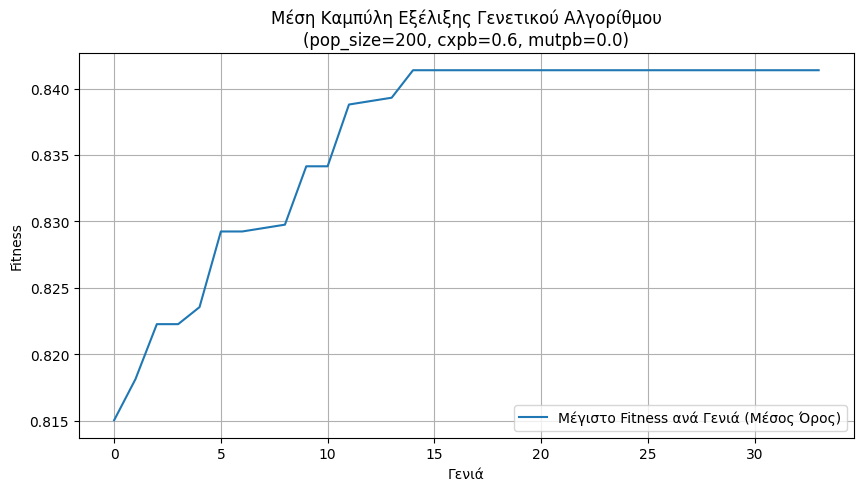

Run 1: Features: [1, 2, 5, 8, 10, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 26, 31, 32, 33, 34] Features used: 20, Accuracy: 0.8465
Best accuracy: 0.8465 with features: [1, 2, 5, 8, 10, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 26, 31, 32, 33, 34]

Parameters 7/10: pop_size=200, cxpb=0.6, mutpb=0.01

Run 1/1
Early stopping at generation 41
Best fitness: 0.8460345855694693

Μέση απόδοση βέλτιστων ατόμων μετά από 1 επαναλήψεις: 0.8460
Μέσος αριθμός γενεών: 41.0


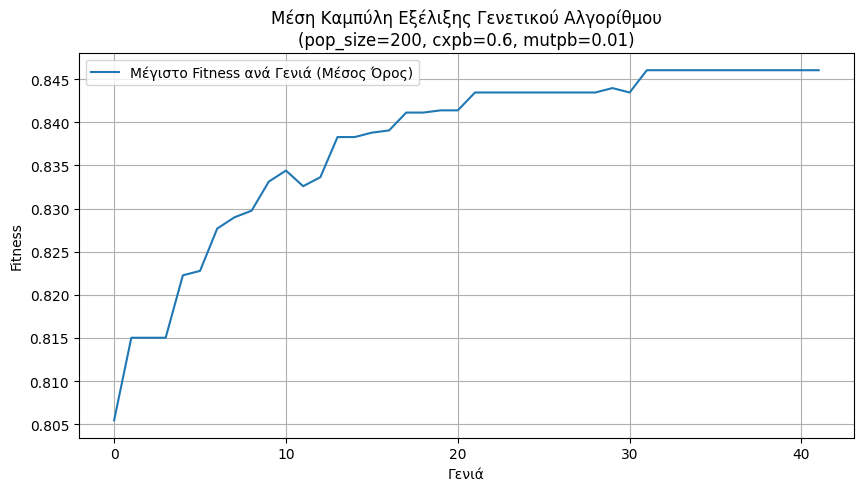

Run 1: Features: [2, 4, 5, 9, 12, 13, 14, 15, 16, 18, 19, 22, 23, 24, 25, 26, 28, 31, 32, 33] Features used: 20, Accuracy: 0.8512
Best accuracy: 0.8512 with features: [2, 4, 5, 9, 12, 13, 14, 15, 16, 18, 19, 22, 23, 24, 25, 26, 28, 31, 32, 33]

Parameters 8/10: pop_size=200, cxpb=0.6, mutpb=0.1

Run 1/1
Early stopping at generation 30
Best fitness: 0.844221824686941

Μέση απόδοση βέλτιστων ατόμων μετά από 1 επαναλήψεις: 0.8442
Μέσος αριθμός γενεών: 30.0


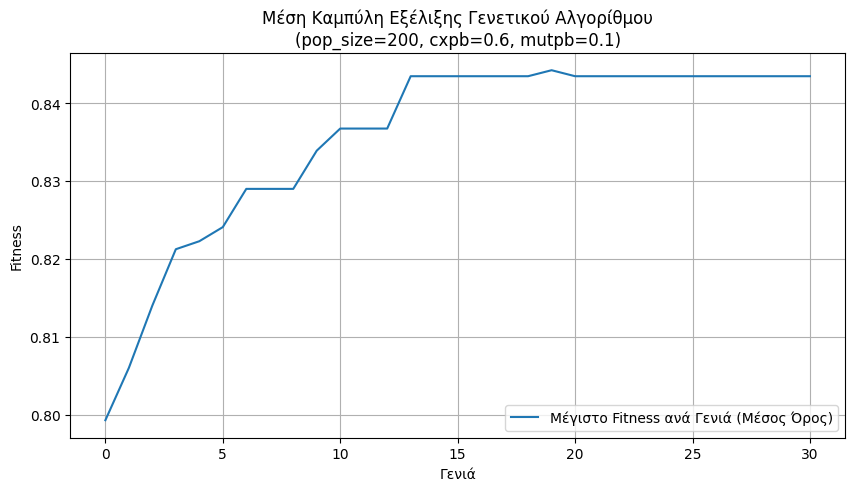

Run 1: Features: [4, 5, 11, 12, 13, 14, 15, 19, 20, 22, 23, 24, 25, 26, 31, 32, 33, 34] Features used: 18, Accuracy: 0.8488
Best accuracy: 0.8488 with features: [4, 5, 11, 12, 13, 14, 15, 19, 20, 22, 23, 24, 25, 26, 31, 32, 33, 34]

Parameters 9/10: pop_size=200, cxpb=0.9, mutpb=0.01

Run 1/1
Early stopping at generation 32
Best fitness: 0.845778175313059

Μέση απόδοση βέλτιστων ατόμων μετά από 1 επαναλήψεις: 0.8458
Μέσος αριθμός γενεών: 32.0


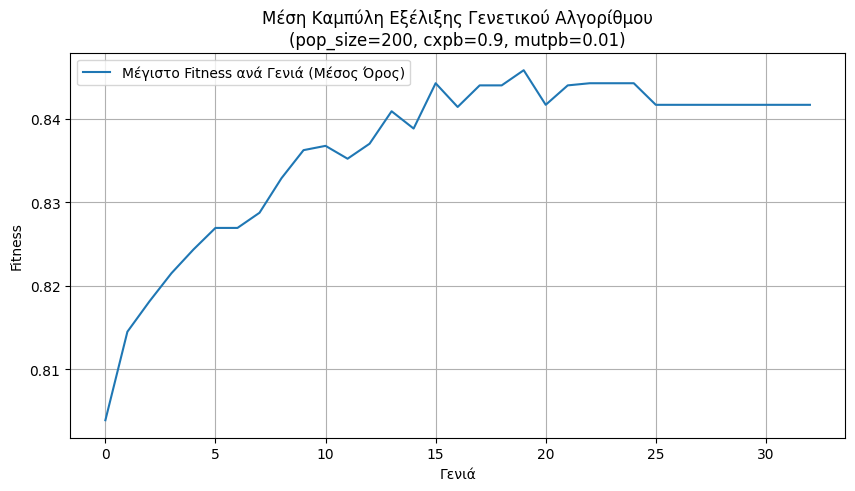

Run 1: Features: [4, 5, 8, 11, 12, 13, 14, 15, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34] Features used: 21, Accuracy: 0.8512
Best accuracy: 0.8512 with features: [4, 5, 8, 11, 12, 13, 14, 15, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34]

Parameters 10/10: pop_size=200, cxpb=0.1, mutpb=0.01

Run 1/1
Early stopping at generation 36
Best fitness: 0.8338938580799046

Μέση απόδοση βέλτιστων ατόμων μετά από 1 επαναλήψεις: 0.8339
Μέσος αριθμός γενεών: 36.0


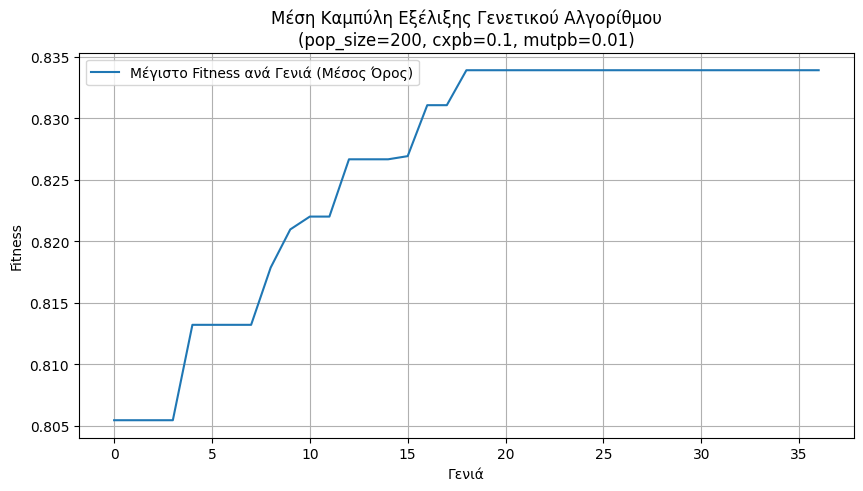

Run 1: Features: [0, 2, 4, 5, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22, 24, 25, 26, 28, 30, 32, 33, 36] Features used: 22, Accuracy: 0.8395
Best accuracy: 0.8395 with features: [0, 2, 4, 5, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22, 24, 25, 26, 28, 30, 32, 33, 36]
Best individual from experiments: [2, 4, 5, 9, 12, 13, 14, 15, 16, 18, 19, 22, 23, 24, 25, 26, 28, 31, 32, 33]


In [3]:
pop_sizes = [
    20, 20, 20, 20, 20, 
    200, 200, 200, 200, 200
]

cxpbs = [
    0.6, 0.6, 0.6, 0.9, 0.1,
    0.6, 0.6, 0.6, 0.9, 0.1
]

mutpbs = [
    0.0, 0.01, 0.1, 0.01, 0.01,
    0.0, 0.01, 0.1, 0.01, 0.01    
]

all_best_individuals = []
all_best_accuracies = []

for i in range(0, 5):
    print(f"\nParameters {i + 1}/{len(pop_sizes)}: pop_size={pop_sizes[i]}, cxpb={cxpbs[i]}, mutpb={mutpbs[i]}")
    
    avg_curve, fitnesses, best_individuals = multiple_runs_ga(n_runs=10, cxpb=cxpbs[i], mutpb=mutpbs[i], pop_size=pop_sizes[i], ngen=1000)
    
    best_acc = -1
    best_indices = None
    
    for i, ind in enumerate(best_individuals):
        selected_features = sum(ind)
        # Evaluate accuracy (without penalty)
        selected_indices = [j for j, bit in enumerate(ind) if bit == 1]
        X_selected = X_val[:, selected_indices]
        X_model_input = np.zeros_like(X_val)
        X_model_input[:, selected_indices] = X_selected
        y_pred = (model.predict(X_model_input, verbose=0) >= 0.5).astype(int).flatten()
        acc = accuracy_score(y_val, y_pred)
        print(f"Run {i+1}: Features: {selected_indices} Features used: {selected_features}, Accuracy: {acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_indices = selected_indices

    print(f"Best accuracy: {best_acc:.4f} with features: {best_indices}")
    all_best_individuals.append(best_indices)
    all_best_accuracies.append(best_acc)
    
for i in range(5, 10):
    print(f"\nParameters {i + 1}/{len(pop_sizes)}: pop_size={pop_sizes[i]}, cxpb={cxpbs[i]}, mutpb={mutpbs[i]}")
    
    avg_curve, fitnesses, best_individuals = multiple_runs_ga(n_runs=1, cxpb=cxpbs[i], mutpb=mutpbs[i], pop_size=pop_sizes[i], ngen=1000)
    
    best_acc = -1
    best_indices = None
    
    for i, ind in enumerate(best_individuals):
        selected_features = sum(ind)
        # Evaluate accuracy (without penalty)
        selected_indices = [j for j, bit in enumerate(ind) if bit == 1]
        X_selected = X_val[:, selected_indices]
        X_model_input = np.zeros_like(X_val)
        X_model_input[:, selected_indices] = X_selected
        y_pred = (model.predict(X_model_input, verbose=0) >= 0.5).astype(int).flatten()
        acc = accuracy_score(y_val, y_pred)
        print(f"Run {i+1}: Features: {selected_indices} Features used: {selected_features}, Accuracy: {acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_indices = selected_indices

    print(f"Best accuracy: {best_acc:.4f} with features: {best_indices}")
    all_best_individuals.append(best_indices)
    all_best_accuracies.append(best_acc)

max_acc_index = np.argmax(all_best_accuracies)
print("Best individual from experiments:", all_best_individuals[max_acc_index])

In [15]:
selected_indices = all_best_individuals[max_acc_index]
X_selected = X_val[:, selected_indices]
X_model_input = np.zeros_like(X_val)
X_model_input[:, selected_indices] = X_selected
y_pred = (model.predict(X_model_input, verbose=0) >= 0.5).astype(int).flatten()
acc = accuracy_score(y_val, y_pred)

print("Selected features:", selected_indices)
print(f"Number of selected features: {len(selected_indices)} / {N_FEATURES}")
print(f"Final accuracy with best individual: {acc:.4f}")

Selected features: [2, 4, 5, 9, 12, 13, 14, 15, 16, 18, 19, 22, 23, 24, 25, 26, 28, 31, 32, 33]
Number of selected features: 20 / 39
Final accuracy with best individual: 0.8512


In [9]:
y_predA = (model.predict(X_val, verbose=0) >= 0.5).astype(int).flatten()
accA = accuracy_score(y_val, y_predA)
print(f"Accuracy without feature selection: {accA:.4f}")

Accuracy without feature selection: 0.8163


Fold 0: Loss=0.5142, MSE=0.1456, Accuracy=0.8163
Fold 1: Loss=0.5358, MSE=0.1546, Accuracy=0.7884
Fold 2: Loss=0.5332, MSE=0.1555, Accuracy=0.7814
Fold 3: Loss=0.4927, MSE=0.1396, Accuracy=0.8209
Fold 4: Loss=0.5322, MSE=0.1543, Accuracy=0.7832
Average Loss: 0.5216
Average MSE: 0.1499
Average Accuracy: 0.7980


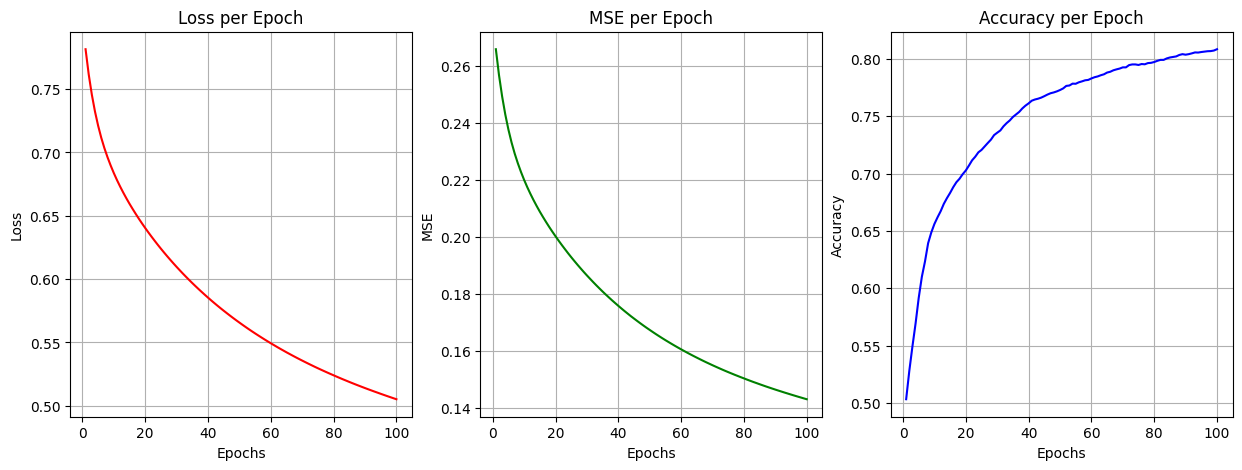

In [21]:
# Αποθήκευση τιμών για το διάγραμμα
avg_loss_per_epoch = np.zeros(epochs)
avg_mse_per_epoch = np.zeros(epochs)
avg_acc_per_epoch = np.zeros(epochs)
lossList = []
mseList = []
accuracyList = []


for j, (train, test) in enumerate(kfold.split(X, Y)):
    # Δημιουργία μοντέλου
    model = Sequential()
    model.add(Input(shape=(I,)))
    model.add(Dense(H, activation=hidden_layer_activation, kernel_regularizer=keras.regularizers.l2(r)))
    model.add(Dense(1, activation=output_activation, kernel_regularizer=keras.regularizers.l2(r)))

    # Compile model
    optimizer = keras.optimizers.SGD(learning_rate=h, momentum=m)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['mse', 'accuracy'])

    # Εκπαίδευση μοντέλου και αποθήκευση ιστορικού
    history = model.fit(X[train], Y[train], epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping])

    # Αποθήκευση της απώλειας και της ακρίβειας ανά εποχή
    avg_loss_per_epoch += np.array(history.history['loss']) / kfold.get_n_splits()
    avg_mse_per_epoch += np.array(history.history['mse']) / kfold.get_n_splits()
    avg_acc_per_epoch += np.array(history.history['accuracy']) / kfold.get_n_splits()

    # Αξιολόγηση μοντέλου
    scores = model.evaluate(X[test], Y[test], verbose=0)
    val_accuracy = scores[2]

    lossList.append(scores[0])
    mseList.append(scores[1])
    accuracyList.append(scores[2])

    print(f"Fold {j}: Loss={scores[0]:.4f}, MSE={scores[1]:.4f}, Accuracy={scores[2]:.4f}")

print(f"Average Loss: {np.mean(lossList):.4f}")
print(f"Average MSE: {np.mean(mseList):.4f}")
print(f"Average Accuracy: {np.mean(accuracyList):.4f}")

# Σχεδίαση των γραφημάτων σύγκλισης
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs + 1), avg_loss_per_epoch, linestyle='-', color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Loss per Epoch")
plt.grid()

# MSE Plot
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs + 1), avg_mse_per_epoch, linestyle='-', color='g')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title(f"MSE per Epoch")
plt.grid()

# Accuracy Plot
plt.subplot(1, 3, 3)
plt.plot(range(1, epochs + 1), avg_acc_per_epoch, linestyle='-', color='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title(f"Accuracy per Epoch")
plt.grid()

plt.show()

In [26]:
X_ga = X[:, selected_indices]


In [27]:
I = X_ga.shape[1]  # Number of columns
H = 2*I

h = 0.001
m = 0.6 # Momentum

r = 0.001

# Split the data into a balanced 5-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True)

hidden_layer_activation = 'relu'  # Activation function for hidden layers
output_activation = 'sigmoid'  # For binary classification

epochs = 100
batch_size = 50

# Early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=5,
    restore_best_weights=True,
)

Fold 0: Loss=0.5082, MSE=0.1546, Accuracy=0.7814
Fold 1: Loss=0.4818, MSE=0.1437, Accuracy=0.8163
Fold 2: Loss=0.4816, MSE=0.1434, Accuracy=0.8047
Fold 3: Loss=0.4674, MSE=0.1358, Accuracy=0.8163
Fold 4: Loss=0.4967, MSE=0.1490, Accuracy=0.8112
Average Loss: 0.4871
Average MSE: 0.1453
Average Accuracy: 0.8060


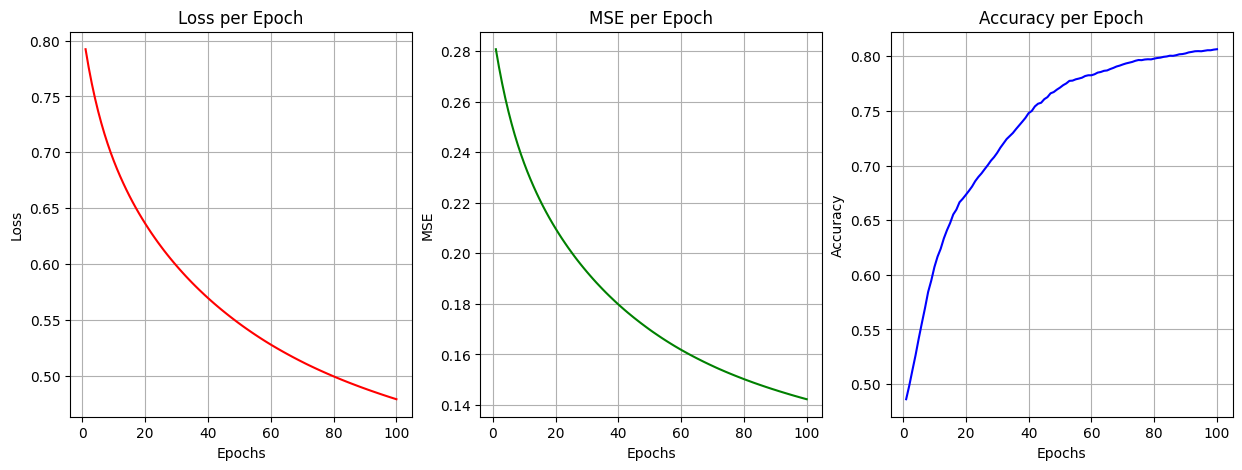

In [29]:
# Αποθήκευση τιμών για το διάγραμμα
avg_loss_per_epoch = np.zeros(epochs)
avg_mse_per_epoch = np.zeros(epochs)
avg_acc_per_epoch = np.zeros(epochs)
lossList = []
mseList = []
accuracyList = []

for j, (train, test) in enumerate(kfold.split(X_ga, Y)):
    # Δημιουργία μοντέλου
    model = Sequential()
    model.add(Input(shape=(I,)))
    model.add(Dense(H, activation=hidden_layer_activation, kernel_regularizer=keras.regularizers.l2(r)))
    model.add(Dense(1, activation=output_activation, kernel_regularizer=keras.regularizers.l2(r)))

    # Compile model
    optimizer = keras.optimizers.SGD(learning_rate=h, momentum=m)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['mse', 'accuracy'])

    # Εκπαίδευση μοντέλου και αποθήκευση ιστορικού
    history = model.fit(X_ga[train], Y[train], epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping])

    # Αποθήκευση της απώλειας και της ακρίβειας ανά εποχή
    avg_loss_per_epoch += np.array(history.history['loss']) / kfold.get_n_splits()
    avg_mse_per_epoch += np.array(history.history['mse']) / kfold.get_n_splits()
    avg_acc_per_epoch += np.array(history.history['accuracy']) / kfold.get_n_splits()

    # Αξιολόγηση μοντέλου
    scores = model.evaluate(X_ga[test], Y[test], verbose=0)
    val_accuracy = scores[2]

    lossList.append(scores[0])
    mseList.append(scores[1])
    accuracyList.append(scores[2])

    print(f"Fold {j}: Loss={scores[0]:.4f}, MSE={scores[1]:.4f}, Accuracy={scores[2]:.4f}")

print(f"Average Loss: {np.mean(lossList):.4f}")
print(f"Average MSE: {np.mean(mseList):.4f}")
print(f"Average Accuracy: {np.mean(accuracyList):.4f}")

# Σχεδίαση των γραφημάτων σύγκλισης
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs + 1), avg_loss_per_epoch, linestyle='-', color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Loss per Epoch")
plt.grid()

# MSE Plot
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs + 1), avg_mse_per_epoch, linestyle='-', color='g')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title(f"MSE per Epoch")
plt.grid()

# Accuracy Plot
plt.subplot(1, 3, 3)
plt.plot(range(1, epochs + 1), avg_acc_per_epoch, linestyle='-', color='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title(f"Accuracy per Epoch")
plt.grid()

plt.show()